# Data Processing


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


import numpy as np

# data = pd.read_csv("MetroPT3.csv")
data = pd.read_csv("RailGuadrs_Clean_Data.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59445 entries, 0 to 59444
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       59445 non-null  int64  
 1   timestamp        59445 non-null  object 
 2   TP2              59445 non-null  float64
 3   TP3              59445 non-null  float64
 4   H1               59445 non-null  float64
 5   DV_pressure      59445 non-null  float64
 6   Reservoirs       59445 non-null  float64
 7   Oil_temperature  59445 non-null  float64
 8   Motor_current    59445 non-null  float64
 9   COMP             59445 non-null  float64
 10  DV_eletric       59445 non-null  float64
 11  Towers           59445 non-null  float64
 12  MPG              59445 non-null  float64
 13  LPS              59445 non-null  float64
 14  Pressure_switch  59445 non-null  float64
 15  Oil_level        59445 non-null  float64
 16  Caudal_impulses  59445 non-null  float64
 17  status      

# Data Introduction

The MetroPT-3 dataset was designed to facilitate the development of predictive maintenance, anomaly detection, and remaining useful life (RUL) prediction models for train compressors using deep learning and machine learning techniques. It comprises multivariate time series data collected from various analog and digital sensors installed on a train compressor. The data, recorded between February and August 2020, includes 15 signals such as pressures, motor current, oil temperature, and electrical signals from air intake valves. This dataset is suitable for incremental training and contains no sensitive information. Data preprocessing involves segmentation, normalization, and feature extraction. While the dataset itself is unlabeled, failure reports provided by the company are available to evaluate the performance of anomaly detection, failure prediction, and RUL estimation algorithms. Notably, the dataset does not contain any missing values.


the link : https://archive.ics.uci.edu/dataset/791/metropt+3+dataset

## Data Overview

In [7]:
print(data.describe().round(2))
print(data.columns)

       Unnamed: 0       TP2       TP3        H1  DV_pressure  Reservoirs  \
count    59445.00  59445.00  59445.00  59445.00     59445.00    59445.00   
mean    784018.09      4.66      8.66      3.90         0.94        8.66   
std     334772.31      4.16      0.62      4.48         1.01        0.62   
min         31.00     -0.03      6.89     -0.03        -0.03        6.89   
25%     566189.00     -0.01      8.16     -0.01        -0.02        8.16   
50%     891860.00      7.27      8.59     -0.00        -0.01        8.59   
75%     906843.00      8.36      9.01      8.82         2.01        9.01   
max    1516860.00     10.61     10.24     10.25         4.95       10.24   

       Oil_temperature  Motor_current      COMP  DV_eletric    Towers  \
count         59445.00       59445.00  59445.00    59445.00  59445.00   
mean             68.98           3.74      0.43        0.57      0.72   
std               8.16           2.42      0.50        0.50      0.45   
min              43.00 

In [8]:
data.head()

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,status
0,562564,2020-04-18 00:00:01,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
1,562565,2020-04-18 00:00:13,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
2,562566,2020-04-18 00:00:24,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
3,562567,2020-04-18 00:00:36,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,562568,2020-04-18 00:00:49,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1


## Cleaning


In [9]:
print(data.columns)
data = data.drop('Unnamed: 0', axis= 1)

Index(['Unnamed: 0', 'timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure',
       'Reservoirs', 'Oil_temperature', 'Motor_current', 'COMP', 'DV_eletric',
       'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level',
       'Caudal_impulses', 'status'],
      dtype='object')


In [10]:

data.min()

timestamp          2020-02-01 00:05:07
TP2                              -0.03
TP3                              6.894
H1                              -0.034
DV_pressure                     -0.032
Reservoirs                       6.892
Oil_temperature                   43.0
Motor_current                   0.0225
COMP                               0.0
DV_eletric                         0.0
Towers                             0.0
MPG                                0.0
LPS                                0.0
Pressure_switch                    0.0
Oil_level                          0.0
Caudal_impulses                    0.0
status                               0
dtype: object

## Convert the timestamp collumn into pandas.DateTime data type standarzation

In [11]:
data.max()

timestamp          2020-09-01 03:45:28
TP2                             10.614
TP3                             10.244
H1                              10.246
DV_pressure                       4.95
Reservoirs                      10.242
Oil_temperature                  89.05
Motor_current                     6.98
COMP                               1.0
DV_eletric                         1.0
Towers                             1.0
MPG                                1.0
LPS                                1.0
Pressure_switch                    1.0
Oil_level                          1.0
Caudal_impulses                    1.0
status                               1
dtype: object

In [12]:
import datetime

#Check the current type of timestamp
print(f"Current type of timestamp is {type(data.timestamp[0])}")

#Convert timestamp to pandas.DateTime ISO 8601
data['timestamp'] = data['timestamp'].apply(pd.to_datetime, format = "%Y-%m-%d %H:%M:%S")

#Re-check the type
print(f"Current type of timestamp is {type(data.timestamp[0])}")

Current type of timestamp is <class 'str'>
Current type of timestamp is <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [13]:
print(data.head(10))

            timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
0 2020-04-18 00:00:01 -0.018  8.248  8.238       -0.024       8.248   
1 2020-04-18 00:00:13 -0.018  8.248  8.238       -0.024       8.248   
2 2020-04-18 00:00:24 -0.018  8.248  8.238       -0.024       8.248   
3 2020-04-18 00:00:36 -0.018  8.248  8.238       -0.024       8.248   
4 2020-04-18 00:00:49 -0.018  8.248  8.238       -0.024       8.248   
5 2020-04-18 00:01:01 -0.018  8.248  8.238       -0.024       8.248   
6 2020-04-18 00:01:13 -0.018  8.248  8.238       -0.024       8.248   
7 2020-04-18 00:01:25 -0.018  8.248  8.238       -0.024       8.248   
8 2020-04-18 00:01:37 -0.018  8.248  8.238       -0.024       8.248   
9 2020-04-18 00:01:49 -0.018  8.248  8.238       -0.024       8.248   

   Oil_temperature  Motor_current  COMP  DV_eletric  Towers  MPG  LPS  \
0            49.45           0.04   1.0         0.0     1.0  1.0  0.0   
1            49.45           0.04   1.0         0.0     1.0  1.0  0.0   

## Add a label feature

In [14]:
#Create a new column for target variable called status, indicate the equipment has deficiencies and need to be maintained
# status = 0; system ups and running no No Failure
# status = 1; system downs and needs recovering ## Failure
labeled_data = data.copy()
labeled_data['status'] = 0
print(labeled_data.head(5))

            timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
0 2020-04-18 00:00:01 -0.018  8.248  8.238       -0.024       8.248   
1 2020-04-18 00:00:13 -0.018  8.248  8.238       -0.024       8.248   
2 2020-04-18 00:00:24 -0.018  8.248  8.238       -0.024       8.248   
3 2020-04-18 00:00:36 -0.018  8.248  8.238       -0.024       8.248   
4 2020-04-18 00:00:49 -0.018  8.248  8.238       -0.024       8.248   

   Oil_temperature  Motor_current  COMP  DV_eletric  Towers  MPG  LPS  \
0            49.45           0.04   1.0         0.0     1.0  1.0  0.0   
1            49.45           0.04   1.0         0.0     1.0  1.0  0.0   
2            49.45           0.04   1.0         0.0     1.0  1.0  0.0   
3            49.45           0.04   0.0         0.0     0.0  0.0  0.0   
4            49.45           0.04   1.0         0.0     1.0  1.0  0.0   

   Pressure_switch  Oil_level  Caudal_impulses  status  
0              1.0        1.0              1.0       0  
1              1.0  

In [15]:
def to_datetime(xs):
  result = []
  format =  "%Y-%m-%d %H:%M:%S"
  for x in xs:
    result.append(pd.to_datetime(x, format = format))
  return result


failure_start_time = to_datetime(["2020-04-18 00:00:00", "2020-05-29 23:30:00", "2020-06-05 10:00:00", "2020-07-15 14:30:00"] )
failure_end_time   = to_datetime(["2020-04-18 23:59:00", "2020-05-30 06:00:00", "2020-06-07 14:30:00", "2020-07-15 19:00:00"] )

print(failure_start_time,"\n", failure_end_time[0].minute)

[Timestamp('2020-04-18 00:00:00'), Timestamp('2020-05-29 23:30:00'), Timestamp('2020-06-05 10:00:00'), Timestamp('2020-07-15 14:30:00')] 
 59


In [16]:
def in_between(x, start, end):

  start_con = x >= start
  end_con = x<= end

  inbetween_con = start_con and end_con
  if inbetween_con:
    return 1
  else:
    return 0

In [17]:
failure_indx = []
for i, (start_time, end_time) in enumerate(zip(failure_start_time, failure_end_time)):
  mask = labeled_data['timestamp'].apply(in_between, start = start_time, end = end_time)
  indx = labeled_data.index[mask == True].tolist()
  failure_indx += indx


print(f" Found {len(failure_indx)} samples representing failure state")

 Found 29607 samples representing failure state


In [18]:
#Set the sample with the timestamp falled between the failure time to 1
# labeled_data['status'].iloc[failure_indx] = 1
labeled_data.loc[failure_indx, 'status'] = 1
print(labeled_data['status'].value_counts())
print(f"We have {labeled_data['status'][labeled_data['status']==1].count()} positve samples" )

0    29838
1    29607
Name: status, dtype: int64
We have 29607 positve samples


In [19]:
print(f"Example of Failure state \n {labeled_data[labeled_data['status']==1].head()}")

Example of Failure state 
             timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
0 2020-04-18 00:00:01 -0.018  8.248  8.238       -0.024       8.248   
1 2020-04-18 00:00:13 -0.018  8.248  8.238       -0.024       8.248   
2 2020-04-18 00:00:24 -0.018  8.248  8.238       -0.024       8.248   
3 2020-04-18 00:00:36 -0.018  8.248  8.238       -0.024       8.248   
4 2020-04-18 00:00:49 -0.018  8.248  8.238       -0.024       8.248   

   Oil_temperature  Motor_current  COMP  DV_eletric  Towers  MPG  LPS  \
0            49.45           0.04   1.0         0.0     1.0  1.0  0.0   
1            49.45           0.04   1.0         0.0     1.0  1.0  0.0   
2            49.45           0.04   1.0         0.0     1.0  1.0  0.0   
3            49.45           0.04   0.0         0.0     0.0  0.0  0.0   
4            49.45           0.04   1.0         0.0     1.0  1.0  0.0   

   Pressure_switch  Oil_level  Caudal_impulses  status  
0              1.0        1.0              1.0    

## splite the dataset

In [20]:
#Seperate Positive samples and Negative sample
pos_data = labeled_data[labeled_data['status'] == 1]
neg_data = labeled_data[labeled_data['status'] == 0]

#Print out the info of 2 dataset
print(f"Positive dataset\n {pos_data.info()}\n")
print(f"Negative dataset\n {neg_data.info()}\n")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29607 entries, 0 to 29606
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        29607 non-null  datetime64[ns]
 1   TP2              29607 non-null  float64       
 2   TP3              29607 non-null  float64       
 3   H1               29607 non-null  float64       
 4   DV_pressure      29607 non-null  float64       
 5   Reservoirs       29607 non-null  float64       
 6   Oil_temperature  29607 non-null  float64       
 7   Motor_current    29607 non-null  float64       
 8   COMP             29607 non-null  float64       
 9   DV_eletric       29607 non-null  float64       
 10  Towers           29607 non-null  float64       
 11  MPG              29607 non-null  float64       
 12  LPS              29607 non-null  float64       
 13  Pressure_switch  29607 non-null  float64       
 14  Oil_level        29607 non-null  float

As we can see, we have around 30K postive samples and 1500K negative sample. This indicates highly imbalanced dataset. Thus, we have to subsample the negative class to balance the training data. To achive this, we will randomly sample 30K negative sample from the set of 1500K sample.

In [21]:
n_positives = int(pos_data['status'].count())
sub_neg_data = neg_data.sample(n_positives, random_state = 42)
print(f"Negative dataset after subsampling {sub_neg_data.info()}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29607 entries, 36986 to 54892
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        29607 non-null  datetime64[ns]
 1   TP2              29607 non-null  float64       
 2   TP3              29607 non-null  float64       
 3   H1               29607 non-null  float64       
 4   DV_pressure      29607 non-null  float64       
 5   Reservoirs       29607 non-null  float64       
 6   Oil_temperature  29607 non-null  float64       
 7   Motor_current    29607 non-null  float64       
 8   COMP             29607 non-null  float64       
 9   DV_eletric       29607 non-null  float64       
 10  Towers           29607 non-null  float64       
 11  MPG              29607 non-null  float64       
 12  LPS              29607 non-null  float64       
 13  Pressure_switch  29607 non-null  float64       
 14  Oil_level        29607 non-null  f

Now, we merge the postive set and negative set into one

In [22]:
merged_data = pd.concat([pos_data, sub_neg_data], axis = 0)
print(f"Merged dataset\n")
merged_data.info()

Merged dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59214 entries, 0 to 54892
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        59214 non-null  datetime64[ns]
 1   TP2              59214 non-null  float64       
 2   TP3              59214 non-null  float64       
 3   H1               59214 non-null  float64       
 4   DV_pressure      59214 non-null  float64       
 5   Reservoirs       59214 non-null  float64       
 6   Oil_temperature  59214 non-null  float64       
 7   Motor_current    59214 non-null  float64       
 8   COMP             59214 non-null  float64       
 9   DV_eletric       59214 non-null  float64       
 10  Towers           59214 non-null  float64       
 11  MPG              59214 non-null  float64       
 12  LPS              59214 non-null  float64       
 13  Pressure_switch  59214 non-null  float64       
 14  Oil_level        59214

## Valeurs abirrantes

In [23]:
def investigate_outliers(data, c):
    q1 = data[c].quantile(0.25)
    q3 = data[c].quantile(0.75)
    iqr = q3 - q1
    ll = q1 - 1.5*iqr
    ul = q3 + 1.5*iqr

    num_outliers = data[data[c] < ll][c].count()  + data[data[c] > ul][c].count()
    if num_outliers>0:
        print(f"Found {num_outliers} oulier(s) for feature {c}")
    return {'col': c, 'n_outliers': num_outliers, 'll': ll, 'ul': ul, 'q1': q1, 'q3':q3}

print("\nDropping outliers ...\n")
clean_data = merged_data.copy()
for i in range(5):
  for c in clean_data.columns:
      if c not in ["Unnamed: 0","timestamp"]:
          cue = investigate_outliers(clean_data, c)
          if cue["n_outliers"] > 0 and (cue["q1"]!= cue["q3"]):
              print(f"Droping {cue['n_outliers']} from column {c}")
              clean_data = clean_data[clean_data[c]> cue["ll"]]
              clean_data = clean_data[clean_data[c]< cue["ul"]]
              print(f"{clean_data.shape[0]} samples left\n")
          elif (cue["q1"]== cue["q3"]):
              print("Skipping .. data has Q1 equals to Q3")
              print(f"{clean_data.shape[0]} rows left\n")


print("\nDropping Completed ...\n")
#Recheck data
for c in clean_data.columns:
    if c not in ["Unnamed: 0","timestamp","COMP", 'status']:
        cue = investigate_outliers(clean_data, c)


Dropping outliers ...

Found 1 oulier(s) for feature Reservoirs
Droping 1 from column Reservoirs
59213 samples left

Found 394 oulier(s) for feature LPS
Skipping .. data has Q1 equals to Q3
59213 rows left

Found 400 oulier(s) for feature Pressure_switch
Skipping .. data has Q1 equals to Q3
59213 rows left

Found 2870 oulier(s) for feature Oil_level
Skipping .. data has Q1 equals to Q3
59213 rows left

Found 1930 oulier(s) for feature Caudal_impulses
Skipping .. data has Q1 equals to Q3
59213 rows left

Found 394 oulier(s) for feature LPS
Skipping .. data has Q1 equals to Q3
59213 rows left

Found 400 oulier(s) for feature Pressure_switch
Skipping .. data has Q1 equals to Q3
59213 rows left

Found 2870 oulier(s) for feature Oil_level
Skipping .. data has Q1 equals to Q3
59213 rows left

Found 1930 oulier(s) for feature Caudal_impulses
Skipping .. data has Q1 equals to Q3
59213 rows left

Found 394 oulier(s) for feature LPS
Skipping .. data has Q1 equals to Q3
59213 rows left

Found 40

In [24]:
#Investigate the columns with the binary values
binary_cols = ['LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']
#Ensure the the binary data is binary
clean_data[binary_cols] = clean_data[binary_cols].apply(np.round)

## III. Exploratory Data Analysis

### 1) Correlation

Describing the correlation between the features, the values closer to 1 or -1 represent a stronger relation.

In [25]:
clean_data.corr().round(2)

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,status
TP2,1.00,-0.42,-0.98,0.81,-0.42,0.74,0.87,-0.98,0.98,-0.52,-0.97,0.06,0.00,0.19,0.14,0.83
TP3,-0.42,1.00,0.54,-0.55,1.00,-0.28,-0.17,0.49,-0.48,0.27,0.48,-0.18,0.01,-0.14,-0.13,-0.55
H1,-0.98,0.54,1.00,-0.83,0.54,-0.73,-0.84,0.99,-0.99,0.54,0.99,-0.07,0.00,-0.20,-0.15,-0.86
DV_pressure,0.81,-0.55,-0.83,1.00,-0.55,0.73,0.72,-0.83,0.83,-0.45,-0.83,-0.05,0.02,0.21,0.17,0.92
Reservoirs,-0.42,1.00,0.54,-0.55,1.00,-0.28,-0.17,0.49,-0.48,0.27,0.48,-0.18,0.01,-0.14,-0.13,-0.55
Oil_temperature,0.74,-0.28,-0.73,0.73,-0.28,1.00,0.80,-0.75,0.76,-0.41,-0.75,0.10,0.02,0.10,0.11,0.81
Motor_current,0.87,-0.17,-0.84,0.72,-0.17,0.80,1.00,-0.87,0.87,-0.47,-0.87,0.06,0.00,0.14,0.10,0.74
COMP,-0.98,0.49,0.99,-0.83,0.49,-0.75,-0.87,1.00,-0.99,0.55,1.00,-0.07,0.06,-0.18,-0.12,-0.86
DV_eletric,0.98,-0.48,-0.99,0.83,-0.48,0.76,0.87,-0.99,1.00,-0.53,-0.99,0.07,0.03,0.19,0.14,0.86
Towers,-0.52,0.27,0.54,-0.45,0.27,-0.41,-0.47,0.55,-0.53,1.00,0.54,-0.04,0.09,-0.07,-0.04,-0.47


We can see that our target variable "status" has high correlation with TP2, H1, DV_pressure, Oil_temparature, Motor_current, COMP, DV_electric and MPG.  

## Correlation

Below shows a Heat map,which can be used to analyse trends, from the below heat map you can see the trends in correlation of data.

<AxesSubplot:>

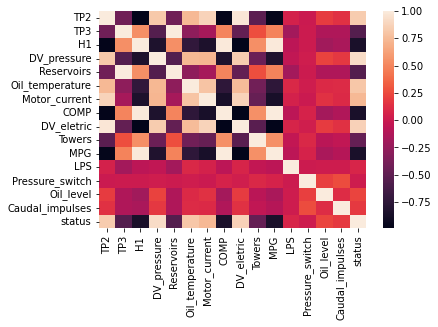

In [26]:
sns.heatmap(clean_data.corr(),annot=False )

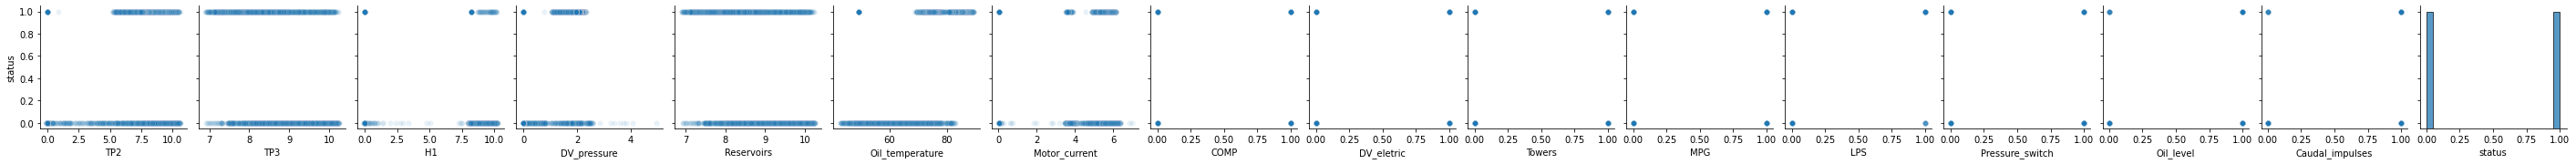

In [27]:
sns.pairplot(clean_data,  y_vars = ['status'] , plot_kws=  {'alpha' : 0.1})

Drawing box plot to find outliers, I plot it on scale data so it is easier to visualize different features' range.
As we can see our preprocessing function work perfectly that leaves no outliers


In [28]:
clean_data.to_csv('RailGuadrs_Clean_Data.csv')
np.savez("RailGuadrs_Clean_Data.npz", clean_data.to_numpy())

# Models


## LinearRegression

In [29]:
data_regression = pd.read_csv('RailGuadrs_Clean_Data.csv')
X = data_regression.iloc[:, 2:-1]
y = data_regression.iloc[:, -1]
X

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,-0.018,8.248,8.238,-0.024,8.248,49.450,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,-0.018,8.248,8.238,-0.024,8.248,49.450,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,-0.018,8.248,8.238,-0.024,8.248,49.450,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,-0.018,8.248,8.238,-0.024,8.248,49.450,0.0400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.018,8.248,8.238,-0.024,8.248,49.450,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59208,9.362,8.940,-0.014,-0.018,8.938,64.000,6.0050,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
59209,-0.012,9.408,9.394,-0.022,9.410,56.525,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
59210,-0.014,8.848,8.834,-0.024,8.846,58.575,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
59211,-0.014,8.182,8.166,-0.018,8.182,55.900,0.0350,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [30]:
y

0        1
1        1
2        1
3        1
4        1
        ..
59208    0
59209    0
59210    0
59211    0
59212    0
Name: status, Length: 59213, dtype: int64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape)
X_train

(47370, 15) (11843, 15)


,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
37015,-0.010,8.130,8.118,-0.018,8.132,54.200,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
39048,-0.014,9.636,9.624,-0.022,9.636,59.400,3.8600,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
17097,7.954,8.160,-0.008,2.084,8.162,75.075,5.5625,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
2804,9.014,8.816,-0.010,2.010,8.820,74.150,5.6950,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
47985,-0.016,9.800,9.790,-0.026,9.798,64.125,3.7500,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45891,-0.016,8.288,8.278,-0.022,8.288,53.000,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
52416,-0.014,8.390,8.380,-0.016,8.398,59.200,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
42613,-0.012,8.858,8.842,-0.020,8.862,57.075,0.0375,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
43567,-0.010,8.146,8.136,-0.014,8.152,63.275,0.0375,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 

model_regression = LogisticRegression()
model_regression.fit(X_train_scaled, y_train)
print(f"Number of iterations: {model_regression.n_iter_}")

Number of iterations: [100]


C:\Users\Saad-rougi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
print(X_train.columns)
print(f"the coef of the model are : {model_regression.coef_}")
print(f"the intercept is : {model_regression.intercept_}")

Index(['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature',
       'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS',
       'Pressure_switch', 'Oil_level', 'Caudal_impulses'],
      dtype='object')
the coef of the model are : [[-1.73254207  0.1511405  -2.31108265  2.87848383 -0.15164017  3.36245929
  -1.48750712 -1.88760664 -3.3206557  -0.05062239 -1.89496984  0.24348983
   0.00667381  0.52991201  0.38831483]]
the intercept is : [-1.17986783]


In [34]:
X_test_scaled = scaler.transform(X_test)

In [35]:
y_pred = model_regression.predict(X_test_scaled)

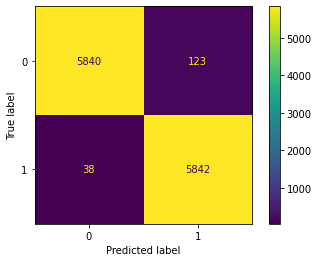

In [36]:
confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [37]:
print(f'the accuracy is {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

the accuracy is 0.9864054715865912
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5963
           1       0.98      0.99      0.99      5880

    accuracy                           0.99     11843
   macro avg       0.99      0.99      0.99     11843
weighted avg       0.99      0.99      0.99     11843



In [ ]:
y_prob = model_regression.predict_proba(X_test)[:, 1]
for threshold in [0.2, 0.4, 0.6, 0.8]:
    y_pred_threshold = (y_prob > threshold).astype(int)
    fpr, tpr, _ = roc_curve(y_test, y_pred_threshold)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Threshold = {:.1f} (AUC = {:.8f})'.format(threshold, roc_auc))
    #print(threshold, format(roc_auc))
# Plot the "Random" line as a dashed line from (0,0) to (1,1) for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

# Label axes and set the title for the plot
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) or Sensitivity')
plt.title('Receiver Operating Characteristic (ROC) Curve with Different Thresholds')
plt.legend(loc='lower right')
plt.show()

## Predict with LogisticRegression

In [39]:
# Example: new sample based on the features
new_sample = {
    'timestamp': [193.293044], 
    'TP2': [-0.018],
    'TP3': [8.248],
    'H1': [8.238],
    'DV_pressure': [-0.024],
    'Reservoirs': [8.248],
    'Oil_temperature': [49.450],
    'Motor_current': [0.0400],
    'COMP': [1.0],
    'DV_eletric': [0.0],
    'Towers': [1.0],
    'MPG': [1.0],
    'LPS': [0.0],
    'Pressure_switch': [1.0],
    'Oil_level': [1.0],
    'Caudal_impulses': [1.0]
}

new_df = pd.DataFrame(new_sample)
new_df

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,193.293044,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [40]:
training_feature_names = X_train.columns
new_df = new_df[training_feature_names]

In [41]:
new_scaled = scaler.transform(new_df)

# Predict the class and probability
y_pred = model_regression.predict(new_scaled)
y_pred_prob = model_regression.predict_proba(new_scaled)[:, 1]

print(f"Prediction (Class): {y_pred}")
print(f"Probability of class 1: {y_pred_prob}")

Prediction (Class): [0]
Probability of class 1: [2.85628828e-05]


# Deploy the Model

In [42]:
import joblib

# Save the trained logistic regression model
joblib.dump(model_regression, 'logistic_regression_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler_logistic.pkl')


['scaler_logistic.pkl']

# Naive Bayes


In [43]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

In [44]:
dataset = pd.read_csv('RailGuadrs_Clean_Data.csv')


# Features and target
features = ['timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
            'Oil_temperature', 'Motor_current', 'COMP', 'DV_eletric',
            'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']
target = 'status'


In [45]:
# Convert timestamp to a scaled numeric value
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'], errors='coerce')
dataset['timestamp'] = (dataset['timestamp'] - dataset['timestamp'].min()) / np.timedelta64(1, 'D')


In [46]:
X = dataset[features]
y = dataset[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Initialize classifiers
gaussian_classifier = GaussianNB()
bernoulli_classifier = BernoulliNB()

In [48]:
# MultinomialNB requires non-negative features, use MinMaxScaler for preprocessing
multinomial_classifier = Pipeline([
    ('Normalize', MinMaxScaler()),
    ('MultinomialNB', MultinomialNB())
])

In [49]:
# Train the models
gaussian_classifier.fit(X_train, y_train)
multinomial_classifier.fit(X_train, y_train)
bernoulli_classifier.fit(X_train, y_train)

BernoulliNB()


GaussianNB Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      5938
           1       0.91      1.00      0.95      5905

    accuracy                           0.95     11843
   macro avg       0.95      0.95      0.95     11843
weighted avg       0.95      0.95      0.95     11843


MultinomialNB Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      5938
           1       0.87      1.00      0.93      5905

    accuracy                           0.93     11843
   macro avg       0.93      0.93      0.93     11843
weighted avg       0.94      0.93      0.93     11843


BernoulliNB Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      5938
           1       0.88      0.99      0.93      5905

    accuracy                           0.93     11843
   macro avg       

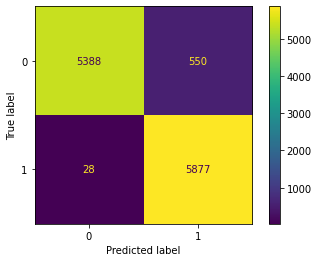

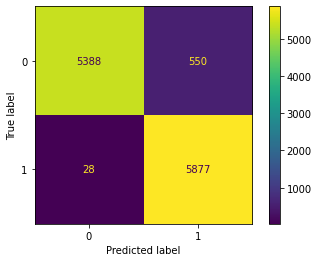

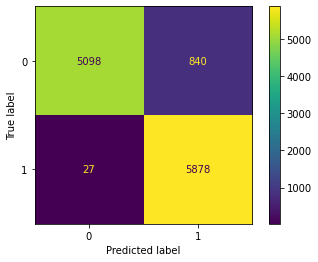

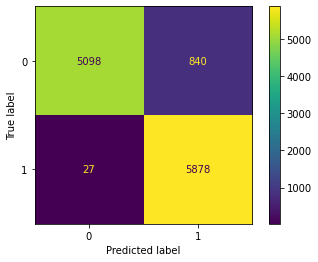

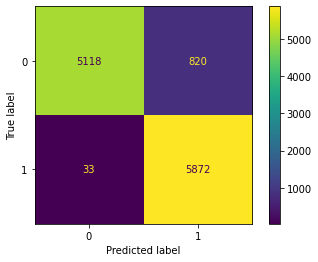

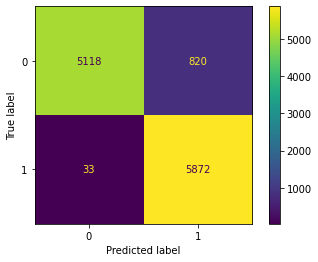

In [50]:
# Evaluate each model
for name, model in [
    ("GaussianNB", gaussian_classifier),
    ("MultinomialNB", multinomial_classifier),
    ("BernoulliNB", bernoulli_classifier)
]:
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred).plot()

In [51]:
new_sample = {
    'timestamp': [1.5],  # Replace with a realistic scaled timestamp
    'TP2': [-0.018],
    'TP3': [8.248],
    'H1': [8.238],
    'DV_pressure': [-0.024],
    'Reservoirs': [8.248],
    'Oil_temperature': [49.450],
    'Motor_current': [0.0400],
    'COMP': [1.0],
    'DV_eletric': [0.0],
    'Towers': [1.0],
    'MPG': [1.0],
    'LPS': [0.0],
    'Pressure_switch': [1.0],
    'Oil_level': [1.0],
    'Caudal_impulses': [1.0]
}

In [52]:
# Create DataFrame
new_df = pd.DataFrame(new_sample)

# Ensure column order matches training data
training_feature_names = [
    'timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
    'Oil_temperature', 'Motor_current', 'COMP', 'DV_eletric',
    'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses'
]
new_df = new_df[training_feature_names]

In [53]:
# Predict the class and probability for the new sample
y_pred_gaussian = gaussian_classifier.predict(new_df)
y_pred_gaussian_prob = gaussian_classifier.predict_proba(new_df)[:, 1]

# Map the prediction to class labels
class_labels = {0: "Not Failure", 1: "Failure"}
predicted_label = [class_labels[label] for label in y_pred_gaussian]

# Output the results
print(f"Prediction (Class): {predicted_label}")
print(f"Probability of Failure: {y_pred_gaussian_prob}")


Prediction (Class): ['Not Failure']
Probability of Failure: [1.04476067e-252]


## Deploy the Naive bayes

In [54]:
joblib.dump(gaussian_classifier, 'gaussian_nb_model.pkl')
joblib.dump(multinomial_classifier, 'multinomial_nb_model.pkl')
joblib.dump(bernoulli_classifier, 'bernoulli_nb_model.pkl')

['bernoulli_nb_model.pkl']

# XGBoost

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# Load dataset
df = pd.read_csv('RailGuadrs_Clean_Data.csv')

# Convert timestamp to numerical values
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['timestamp'] = (df['timestamp'] - df['timestamp'].min()) / pd.Timedelta(days=1)

# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0'])

# Display the first rows of the cleaned dataset
print(df.head())


In [ ]:
# Features and target
X = df.drop(columns=['status'])  # All columns except 'status'
y = df['status']  # Target column


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Initialize XGBoost model
xgb_model = XGBClassifier(
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    objective='binary:logistic',
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

print("Model training completed!")


In [ ]:
y_pred = xgb_model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


In [ ]:
import joblib

# Save the model
joblib.dump(xgb_model, 'xgb_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler_xgb.pkl')

print("Model and scaler saved successfully!")

In [ ]:
# Load the saved model
xgb_model = joblib.load('xgb_model.pkl')
scaler = joblib.load('scaler_xgb.pkl')


# Example new data
new_sample = {
    'timestamp': [1.5],  # Replace with a realistic scaled timestamp
    'TP2': [30.018],
    'TP3': [8.248],
    'H1': [25.238],
    'DV_pressure': [5.024],
    'Reservoirs': [-88.248],
    'Oil_temperature': [80.450],
    'Motor_current': [10.0400],
    'COMP': [0.0],
    'DV_eletric': [0.0],
    'Towers': [0.0],
    'MPG': [0.0],
    'LPS': [1.0],
    'Pressure_switch': [0.0],
    'Oil_level': [1.0],
    'Caudal_impulses': [1.0]
}


# Convert to DataFrame
new_df = pd.DataFrame(new_sample)

# Scale the new data
new_df_scaled = scaler.transform(new_df)

# Predict
prediction = xgb_model.predict(new_df_scaled)
print("Prediction (Class):", "Failure" if prediction[0] == 1 else "Normal")


# DeepLearning

##  dataset Preparation

In [ ]:
# Load dataset
df = pd.read_csv('RailGuadrs_Clean_Data.csv')

# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'timestamp'])

# Drop any remaining NaN values
df = df.dropna()

# Features and target
X = df.drop(columns=['status'])  # All columns except 'status'
y = df['status']  # Target column

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam



# Load dataset
df = pd.read_csv('RailGuadrs_Clean_Data.csv')

# Convert timestamp to numerical values
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['timestamp'] = (df['timestamp'] - df['timestamp'].min()) / pd.Timedelta(days=1)

# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0'])

# Features and target
X = df.drop(columns=['status'])
y = df['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Load dataset
df = pd.read_csv('RailGuadrs_Clean_Data.csv')

# Convert timestamp to numerical values
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['timestamp'] = (df['timestamp'] - df['timestamp'].min()) / pd.Timedelta(days=1)

# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0'])

# Features and target
X = df.drop(columns=['status'])
y = df['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer + first hidden layer
    Dense(32, activation='relu'),  # Second hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])



# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


In [ ]:
# Save the model
model.save('neural_net_model.h5')

# Save the scaler
import joblib
joblib.dump(scaler, 'scaler_net.pkl')

print("Model and scaler saved successfully!")
